In [97]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import time
import torch.nn as nn
import torch.optim as optim
import numpy as np

#Ici on prend des images de réalité terrain

data_dir = "/home/lbenboudiaf/Bureau/ImagesClassification/dataset/GroceryStoreDataset/dataset/OneClasse"
model_name = "squeezenet"
num_classes = 3
batch_size = 8
num_epochs = 100 #Valeur Initiale par défaut comme dans le TP du Prof 
feature_extract = True # Extraction des caractéristique

In [98]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    #Tableau "losses" afin de stocker toutes les valeurs calculer.
    losses_train = []
    losses_val = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # récupéré le model et calculer sa fonction loss 
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase, Backward 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            #On stock les valeurs de loss dans un tableau. 
            if phase == 'train': 
                losses_train.append(epoch_loss)
            else:
                losses_val.append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, losses_train, losses_val

In [99]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [100]:
#Definition du model Squeezenet.

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "squeezenet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    else:
        print("Invalid model name")
        exit()

    return model_ft, input_size

# Initialisé le model pour ce dataset 
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [101]:
import os
# Augmentation et normalisation de données pour le jeux d'apprentissage.  
# Application de filtres et transformation sur la données. 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders ...")

# Generation de jeux d'apprentissage et de validation et de test 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val', 'test']}

# Creation des dataloaders pour jeux d'apprentissage et de validation et test. 
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) 
                    for x in ['train', 'val', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders ...


In [102]:
# Envoyer le model au GPU
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observation des paramètres sont optimisé 
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [103]:
import copy 

#fonction de loss
criterion = nn.CrossEntropyLoss()

# Envoyer le jeux de d'apprentissage et de validation, EVALUATION DU Model. 
# Premier essaye avec 15 epoche, déduction le nombre optimale d'époche = 5. 
# Deuxième essaye meilleur resultat
model_ft, hist, loss_train, loss_val = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs, is_inception=(model_name=="inception"))


Epoch 0/99
----------
train Loss: 0.9014 Acc: 0.5980
val Loss: 0.6454 Acc: 0.7500
Epoch 1/99
----------
train Loss: 0.3515 Acc: 0.8615
val Loss: 0.5656 Acc: 0.7770
Epoch 2/99
----------
train Loss: 0.2551 Acc: 0.9392
val Loss: 0.5137 Acc: 0.8007
Epoch 3/99
----------
train Loss: 0.1962 Acc: 0.9459
val Loss: 0.5032 Acc: 0.7939
Epoch 4/99
----------
train Loss: 0.1671 Acc: 0.9561
val Loss: 0.4765 Acc: 0.8007
Epoch 5/99
----------
train Loss: 0.1408 Acc: 0.9696
val Loss: 0.4249 Acc: 0.8581
Epoch 6/99
----------
train Loss: 0.1261 Acc: 0.9696
val Loss: 0.4155 Acc: 0.8412
Epoch 7/99
----------
train Loss: 0.1101 Acc: 0.9797
val Loss: 0.3882 Acc: 0.8277
Epoch 8/99
----------
train Loss: 0.0842 Acc: 0.9797
val Loss: 0.3927 Acc: 0.8378
Epoch 9/99
----------
train Loss: 0.0804 Acc: 0.9865
val Loss: 0.4489 Acc: 0.8041
Epoch 10/99
----------
train Loss: 0.0757 Acc: 0.9831
val Loss: 0.4893 Acc: 0.7804
Epoch 11/99
----------
train Loss: 0.0805 Acc: 0.9831
val Loss: 0.3938 Acc: 0.8142
Epoch 12/99
--

train Loss: 0.0076 Acc: 1.0000
val Loss: 0.3942 Acc: 0.8311
Training complete in 27m 27s
Best val Acc: 0.895270


import matplotlib.pyplot as plt
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.figure(figsize=(10,10))
plt.show()

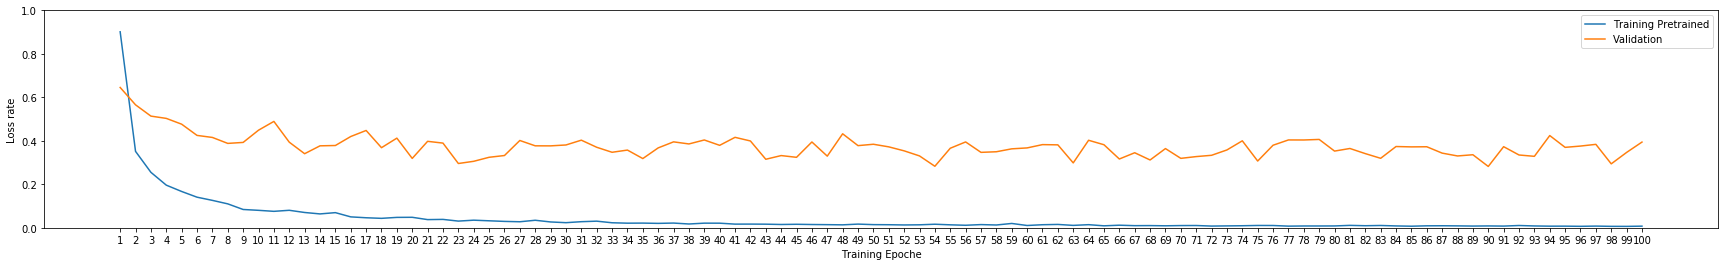

In [159]:
#Create plot of Accuarcy train and validation. 
import matplotlib.pyplot as plt
plt.xlabel("Training Epoche")
plt.ylabel("Loss rate")
plt.plot(range(1,num_epochs+1),loss_train,label="Training Pretrained")
plt.plot(range(1,num_epochs+1),loss_val,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.rcParams["figure.figsize"] = (30, 4)
plt.show()